# Assignment \# 1: Logistic Regression, MIMIC-IV, and 48-Hour Mortality Prediction
## Fall 2023 BINF 4008 / COMS 4995: Advanced Machine Learning for Health and Medicine 

This notebook contains the programming component for Assignment \#1 worth 50 points.

As mentioned in the written assignment instructions, your submission should contain:

- ```{Your UNI}_assignment_1_written.pdf```: A ```PDF``` file with your answers for the written questions typeset in $\LaTeX$.
- ```{Your UNI}_assignment_1_code.ipynb```: Your answers for the programming questions as a ```Jupyter``` notebook.
- ```{Your UNI}_assignment_1_code.{filetype}```: The same ```Jupyter``` notebook as either a ```PDF``` document or ```html``` file.

Best of luck!

## 1. Logistic Regression and Gradient Descent

1. Get the ```Iris``` dataset using the  ```load_iris()``` function from ```sklearn.datasets```. Implement gradient descent for logistic regression with L1 regularization using the base ```numpy``` package and a 80:20 train:test split. Plot the loss curve and ROC curves, and report AUROC and accuracy score for each class.
    - You may use ```sklearn.preprocessing``` and ```sklearn.model_selection``` for this question but **not** ```sklearn.linear_model```.
    - Don't forget that the ```Iris``` dataset is a 3-class classification problem and to add a bias term to your model!
2. Run the model for at least 5 additional different regularization strength values. Plot weights using ```matplotlib.pyplot.stem```.

In [123]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [124]:
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.2
)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [125]:
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000, alpha=0):
        self.lr = lr
        self.epochs = epochs
        self.alpha = alpha
        self.coef_ = None

    def fit(self, X, y):
        num_classes = len(np.unique(y))
        num_features = X.shape[1]
        self.coef_ = np.zeros((num_features, num_classes))
        losses = []
        for epoch in range(self.epochs):
            softmax_scores = self.softmax(X @ self.coef_)
            gradients = self.calculate_gradient(X, y, softmax_scores)
            self.coef_ -= self.lr * gradients
            loss = self.calculate_loss(X, y, softmax_scores)
            losses.append(loss)
        return losses

    def calculate_gradient(self, X, y, softmax_scores):
        m, num_features = X.shape
        m, num_classes = softmax_scores.shape
        gradient = np.zeros((num_features, num_classes))
        for class_idx in range(num_classes):
            y_binary = y == class_idx
            gradient[:, class_idx] = X.T @ (softmax_scores[:, class_idx] - y_binary)
        l1_gradient = self.alpha * np.sign(self.coef_)
        gradient += l1_gradient
        return gradient

    def calculate_loss(self, X, y, softmax_scores):
        num_rows = X.shape[0]
        loss = 0
        for class_idx in np.unique(y):
            y_binary = y == class_idx
            loss -= np.sum(y_binary * np.log(softmax_scores[:, class_idx]))
        l1_loss = self.alpha * np.sum(np.abs(self.coef_))
        return (loss + l1_loss) / num_rows

    def predict(self, X):
        return np.argmax(self.softmax(X @ self.coef_), axis=1)

    def softmax(self, xs):
        """Compute softmax values for each sets of scores in x.

        softmax(np.array([-1, 0, 3, 5])) = [0.0021657, 0.00588697, 0.11824302, 0.87370431]
        """
        e_x = np.exp(xs - np.max(xs, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

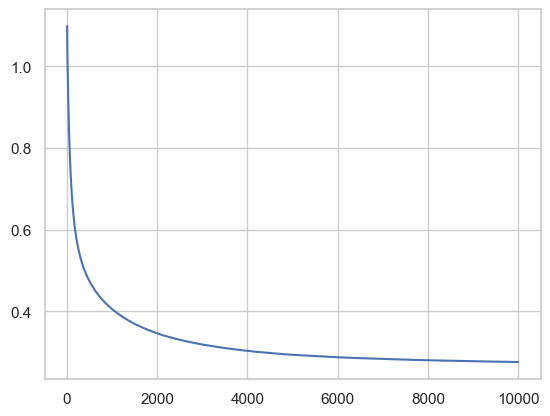

Train accuracy:  0.975
Test accuracy:  0.9666666666666667


In [126]:
log_model = LogisticRegression(lr=0.0001, epochs=10000, alpha=1)
losses = log_model.fit(X_train, y_train)
plt.plot(losses)
plt.show()
print("Train accuracy: ", np.mean(log_model.predict(X_train) == y_train))
print("Test accuracy: ", np.mean(log_model.predict(X_test) == y_test))

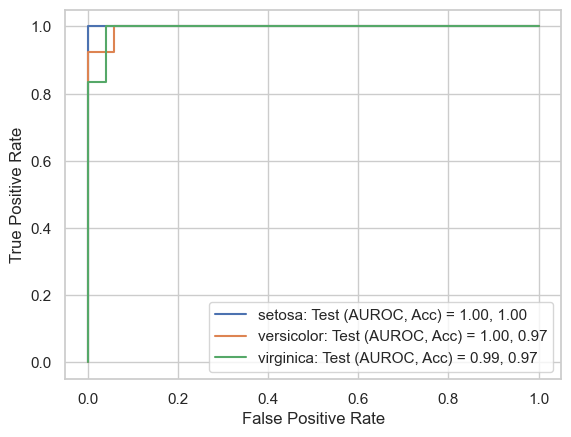

In [127]:
y_probs = log_model.softmax(X_test @ log_model.coef_)
y_preds = log_model.predict(X_test)

for i in range(y_probs.shape[1]):
    y_binary = y_test == i
    y_pred_binary = y_preds == i

    fpr, tpr, _ = roc_curve(y_binary, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    class_acc = np.mean(y_pred_binary == y_binary)
    plt.plot(
        fpr,
        tpr,
        label=f"{data.target_names[i]}: Test (AUROC, Acc) = {roc_auc:.2f}, {class_acc:.2f}",
    )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

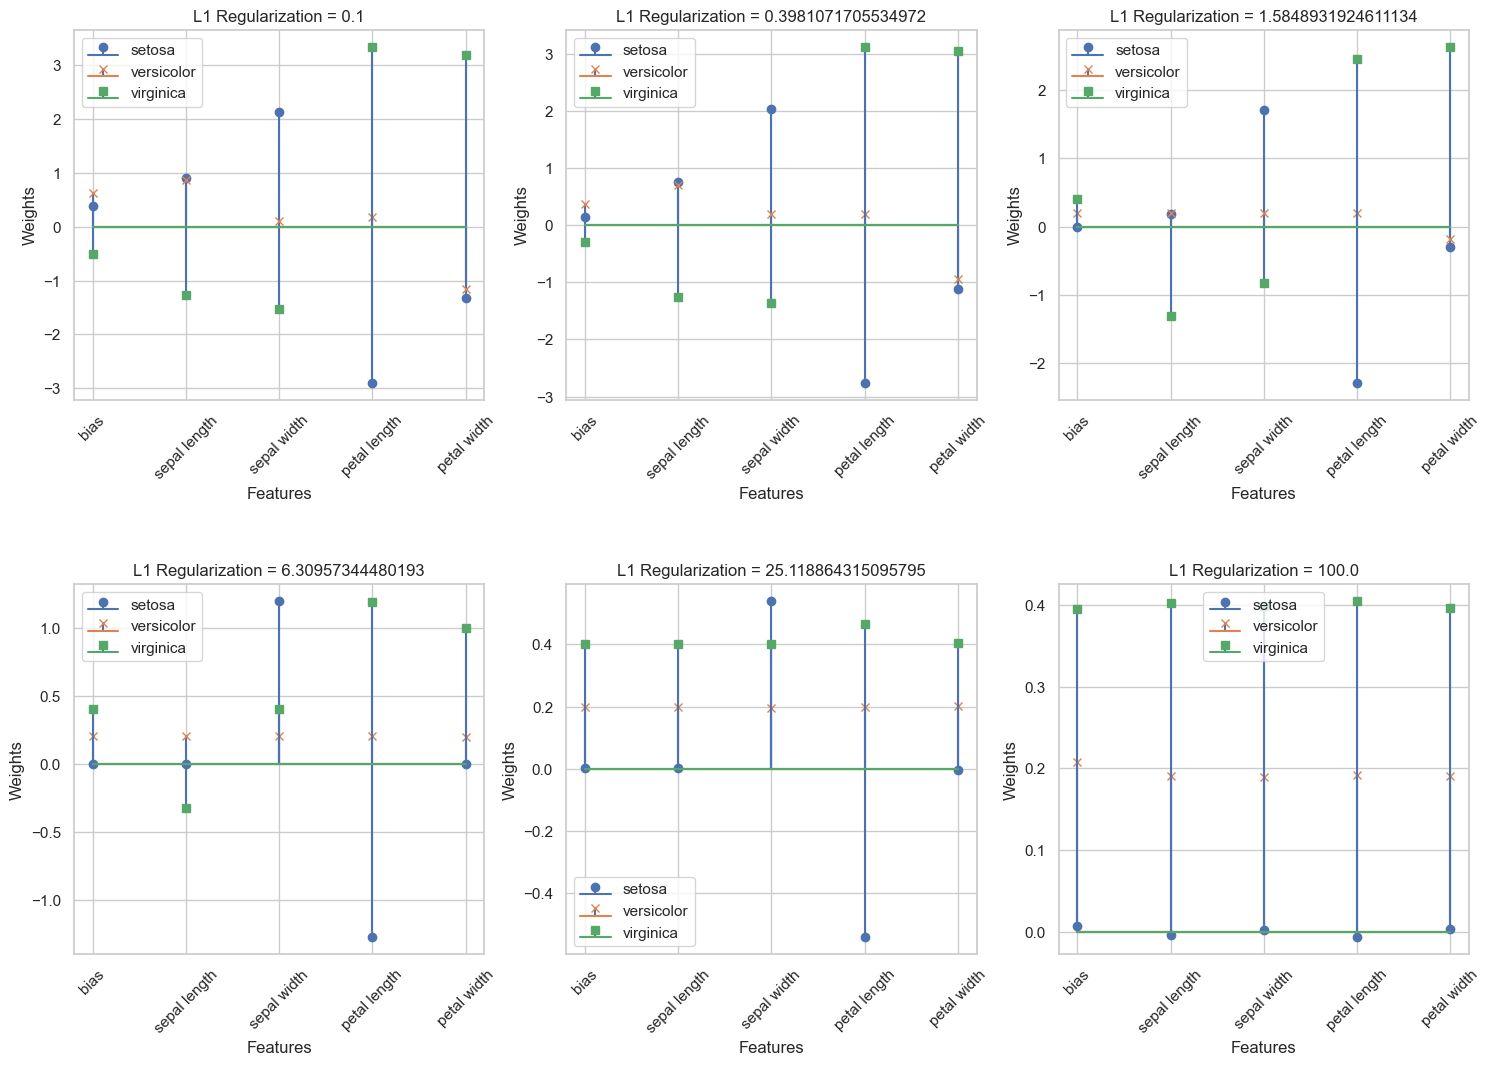

In [128]:
alphas = np.logspace(-1, 2, 6)
weights = {}
test_dict = {}
for alpha in alphas:
    log_model = LogisticRegression(lr=0.0001, epochs=10000, alpha=alpha)
    losses = log_model.fit(X_train, y_train)
    train_preds = log_model.predict(X_train)
    test_preds = log_model.predict(X_test)
    test_softmax = log_model.softmax(X_test @ log_model.coef_)
    test_loss = log_model.calculate_loss(X_test, y_test, test_softmax)

    # find the average auc
    y_probs = log_model.softmax(X_test @ log_model.coef_)
    y_preds = log_model.predict(X_test)
    auc_list = []
    for i in range(y_probs.shape[1]):
        y_binary = y_test == i
        y_pred_binary = y_preds == i
        fpr, tpr, _ = roc_curve(y_binary, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
    avg_auc = np.mean(auc_list)
    test_dict[alpha] = {
        "train loss": losses[-1],
        "test loss": test_loss,
        "train acc": np.mean(train_preds == y_train),
        "test acc": np.mean(test_preds == y_test),
        "avg auc": avg_auc,
    }
    weights[alpha] = log_model.coef_
plt.figure(figsize=(18, 12))
for i, (alpha, weight) in enumerate(weights.items()):
    plt.subplot(2, 3, i + 1)
    # make space between plots
    plt.subplots_adjust(hspace=0.5)
    plt.stem(
        weight[:, 0], markerfmt="C0o", basefmt="C0-", label=f"{data.target_names[0]}"
    )
    plt.stem(
        weight[:, 1] + 0.2,
        markerfmt="C1x",
        basefmt="C1-",
        label=f"{data.target_names[1]}",
    )
    plt.stem(
        weight[:, 2] + 0.4,
        markerfmt="C2s",
        basefmt="C2-",
        label=f"{data.target_names[2]}",
    )
    plt.title(f"L1 Regularization = {alpha}")
    plt.xlabel("Features")
    plt.ylabel("Weights")
    plt.xticks(
        range(5), ["bias", "sepal length", "sepal width", "petal length", "petal width"]
    )
    plt.xticks(rotation=45)
    plt.legend()
plt.show()

In [129]:
# print the output of val_dict pretty with 2 decimal places, round the index to 2 decimal places
print("Test Set Results:")
test_dict = pd.DataFrame(test_dict).T
test_dict = test_dict.round(2)
test_dict.index = test_dict.index.round(2)
print(test_dict)

Test Set Results:
        train loss  test loss  train acc  test acc  avg auc
0.10          0.13       0.22       0.98      0.97     1.00
0.40          0.19       0.41       0.98      0.97     1.00
1.58          0.34       0.87       0.98      0.97     0.99
6.31          0.64       1.40       0.92      0.80     0.99
25.12         0.97       1.73       0.69      0.57     0.91
100.00        1.15       1.40       0.37      0.20     0.78


### Discuss which parameter you will use for the Iris dataset and why.
I would use the regularization parameter of $\alpha$ = 1.58 because on the unseen test set it has the highest accuracy score and the highest AUROC score, while minimizing the complexity of the model. To make sure this is generalizable, there should be an additional evaluation set that is not used for hyperparameter tuning.

_________________

## 2. MIMIC-IV Preprocessing

1. Build your study cohort using your cohort definition from question 2.1 in the written questions. Visualize the distributions for the following:
- Demographic features: age, gender, insurance, racial identity.
- Vitals: Blood pressure, oxygen-levels.
- Lab values.
- Label presence.

2. Remove outlier patients based on out-of-range values. Some resources you may want to explore include:
- Tables for acceptable ranges for physiological variables.
- Prior work on ML-based ICU mortality prediction.

In [1]:
import os
from tableone import TableOne
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import gc
from datetime import datetime

from preprocess import *
from get_tables import *

## Problem Definition

We are attempting to train a classifier to predict 48-hour in-hospital mortality using data collected in the first 24-hours of an ICU stay.

## Getting File Paths, Organizing Unique Identifiers

From the official [Data Description for MIMIC-IV](https://physionet.org/content/mimiciv/2.2/) we know we have two sets of folders:
- ```hosp```: data from the entire hospital.
- ```icu```: data from the iMDSoft system used in BIDMC's ICU units.

Using the ```get_files_of_type()``` function defined from the block above, we're going to get a ```dict``` with the file name as the ```key``` and the filepath as the  ```value```.

We'll start by using the ```admissions``` table from the ```hosp``` and the ```icustays``` table from the ```icu```.

Note that the ```admissions``` table has ```subject_id```, ```hadm_id``` columns while the  ```icustays``` table has columns ```subject_id```, ```hadm_id```, and ```stay_id``` columns. The relationships between the UIDs as follows:
- Subjects and ```subject_id``` have a one-to-one relationship.
- Each ```hadm_id``` is tied to one admission to the hospital (not necessarily the ICU) for a given patient. One ```subject_id``` may have several ```hadm_id``` associated with it.
- Each ```stay_id``` is tied to one stay at the ICU. One ```hadm_id``` may have several ```stay_id``` associated with it.

Therefore, we have to filter out ```stay_id``` with lengths of stay longer than 24 hours and get their respective timestamps from ICU admission to discharge. Additionally, we have to pull additional data from tables in both in the ```hosp``` and the ```icu``` folders. For things like patient demographic information (patient gender, age) we'll match using ```subject_id```, while for other values of interest (lab values, comorbidities, etc.) we'll use ```hadm_id``` and the relative dates of the events.

In [2]:
# Get dictionary of paths to csvs
MIMIC_HOSP_PARENT_PATH = os.path.join("D:", "AIDA", "data", "mimic-iv", "iv", "hosp")
MIMIC_ICU_PARENT_PATH = os.path.join("D:", "AIDA", "data", "mimic-iv", "iv", "icu")

SAVEDIR = os.getcwd()

assert os.path.isdir(MIMIC_HOSP_PARENT_PATH), "MIMIC hospital folder path is not valid"
assert os.path.isdir(MIMIC_ICU_PARENT_PATH), "MIMIC icu folder path is not valid"
hosp_paths = get_files_of_type(MIMIC_HOSP_PARENT_PATH, "csv", as_dict=True)
icu_paths = get_files_of_type(MIMIC_ICU_PARENT_PATH, "csv", as_dict=True)
print(f"Hospital tables:\n{sorted(hosp_paths.keys())}\n")
print(f"ICU tables:\n{sorted(icu_paths.keys())}")

SCRATCH = True

if SCRATCH:
    print("Reading in data from scratch")
    # icu stays records
    icustays_df = pd.read_csv(icu_paths["icustays"])
    # hospital admissions records has los (length of stay)
    admissions_df = pd.read_csv(hosp_paths["admissions"])
    # datetime conversion
    icustays_df = dataframe_datetime(icustays_df)
    admissions_df = dataframe_datetime(admissions_df)

    # check that all hadm_ids for icu stays table are in the admissions table
    assert set(icustays_df["hadm_id"]).issubset(set(admissions_df["hadm_id"]))
else:
    icustays_df = pd.read_csv(os.path.join(SAVEDIR, "data", "icustays.csv"))

Hospital tables:
['admissions', 'd_hcpcs', 'd_icd_diagnoses', 'd_icd_procedures', 'd_labitems', 'diagnoses_icd', 'drgcodes', 'emar', 'emar_detail', 'hcpcsevents', 'labevents', 'microbiologyevents', 'omr', 'patients', 'pharmacy', 'poe', 'poe_detail', 'prescriptions', 'procedures_icd', 'provider', 'services', 'transfers']

ICU tables:
['caregiver', 'chartevents', 'd_items', 'datetimeevents', 'icustays', 'ingredientevents', 'inputevents', 'outputevents', 'procedureevents']
Reading in data from scratch


In [3]:
if SCRATCH:
    print("Reading in data from scratch")
    # add additional columns fo 48-hour ICU mortality and hospital admissions to icu stay table
    # keep only icustays with lengths of stay greater or equal to 24 hours
    ICU_LOS_MIN = 1
    icustays_df = icustays_df[icustays_df["los"] >= ICU_LOS_MIN]
    icu_hadm_ids = set(icustays_df["hadm_id"]) & set(admissions_df["hadm_id"])
    admissions_df = admissions_df[admissions_df["hadm_id"].isin(icu_hadm_ids)]
    subjects = set(admissions_df["subject_id"])

    # sourcery skip: identity-comprehension
    hadm_id_deathtime_dict = {
        hadm_id: deathtime
        for hadm_id, deathtime in admissions_df[
            admissions_df["hospital_expire_flag"] == 1
        ].apply(lambda row: (row["hadm_id"], row["deathtime"]), 1)
    }
    admission_time_dict = {
        hadm_id: admittime
        for hadm_id, admittime in admissions_df.apply(
            lambda row: (row["hadm_id"], row["admittime"]), 1
        )
    }
    icustays_df["admittime"] = icustays_df.apply(
        lambda row: admission_time_dict[row["hadm_id"]], 1
    )
    icustays_df["deathtime"] = icustays_df.apply(
        lambda row: hadm_id_deathtime_dict[row["hadm_id"]]
        if row["hadm_id"] in hadm_id_deathtime_dict
        else np.nan,
        1,
    )
    icustays_df["48_hour_mortality_flag"] = icustays_df.apply(
        lambda row: ((row["deathtime"] - row["intime"]) / pd.Timedelta(hours=1) <= 48)
        & ((row["deathtime"] - row["intime"]) / pd.Timedelta(hours=1) >= 24),
        1,
    )
    print(Counter(icustays_df["48_hour_mortality_flag"]))

    print(
        f'Label prevelance: {len(set(icustays_df["hadm_id"]))=}, {len(set(admissions_df["hadm_id"]))=}'
    )
    print(f"Number of admissions: {admissions_df.shape[0]}")

    # get subject age and gender
    patients_df = pd.read_csv(hosp_paths["patients"])
    patients_df = patients_df[patients_df["subject_id"].isin(subjects)]
    print(patients_df.shape)
    display(patients_df.head(1))

    # Female is 1, Male is 0
    patients_df["gender"] = np.array(patients_df["gender"] == "F").astype(int)

    anchor_age_tuples = patients_df.apply(
        lambda row: (row["subject_id"], row["anchor_age"], row["anchor_year"]), 1
    )

    anchor_age_dict = {
        subject_id: {"anchor_age": anchor_age, "anchor_year": anchor_year}
        for subject_id, anchor_age, anchor_year in anchor_age_tuples
    }

    clean_mem(anchor_age_tuples)
    gender_dict = dict(zip(patients_df["subject_id"], patients_df["gender"]))
    icustays_df["age"] = icustays_df.apply(
        lambda row: anchor_age_dict[row["subject_id"]]["anchor_age"]
        + (row["intime"].year - anchor_age_dict[row["subject_id"]]["anchor_year"]),
        1,
    )
    clean_mem(patients_df)
    clean_mem(anchor_age_dict)

    # add the age and gender column
    icustays_df["age"] = icustays_df.apply(lambda row: min(row["age"], 90), 1)
    icustays_df["gender"] = icustays_df.apply(
        lambda row: gender_dict[row["subject_id"]], 1
    )

    clean_mem(gender_dict)
    length = icustays_df.shape[0]
    # add the race and insurance columns to the icustays table from the admissions table
    icustays_df = pd.merge(
        icustays_df,
        admissions_df[["hadm_id", "race", "insurance"]],
        on="hadm_id",
        how="left",
        suffixes=("", "_adm"),
    )

    assert length == icustays_df.shape[0]
icustays_df = dataframe_datetime(icustays_df)
print(icustays_df.shape)
icustays_df.head(1)

Reading in data from scratch
Counter({False: 56818, True: 916})
Label prevelance: len(set(icustays_df["hadm_id"]))=53034, len(set(admissions_df["hadm_id"]))=53034
Number of admissions: 53034
(42264, 6)


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
40,10001217,F,55,2157,2011 - 2013,NaN


(57734, 15)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,deathtime,48_hour_mortality_flag,age,gender,race,insurance
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,NaT,False,55,1,WHITE,Other


In [4]:
# check if file exists, if not create it
if not os.path.exists(os.path.join(SAVEDIR, "data", "icustays.csv")):
    icustays_df.to_csv(os.path.join(SAVEDIR, "data", "icustays.csv"), index=False)

# Analyze Missingness in icustays_df

# Visualizations for icustays_df

In [5]:
#clean up race col
import re
def clean_race(col):
    string = re.sub(r'ASIAN.*', 'ASIAN', col)
    string = re.sub(r'WHITE.*', 'WHITE', string)
    string = re.sub(r'BLACK.*', 'BLACK', string)
    string = re.sub(r'HISPANIC.*', 'HISPANIC', string)
    string = re.sub(r'UNABLE.*', 'UNKNOWN', string)
    string = re.sub(r'PATIENT.*', 'UNKNOWN', string)
    string = re.sub(r'PORT.*', 'SOUTH AMERICAN', string)
    string = re.sub(r'MULTIPLE.*', 'OTHER', string)
    string = re.sub(r'NATIVE.*', 'OTHER', string)
    string = re.sub(r'SOUTH AMERICAN.*', 'OTHER', string)
    string = re.sub(r'AMERICAN.*', 'OTHER', string)
    
    return string
icustays_df['race']=icustays_df.race.apply(clean_race)

icustays_df.race.value_counts(normalize=True, dropna=False)

race
WHITE       0.678993
UNKNOWN     0.108584
BLACK       0.104479
OTHER       0.041934
HISPANIC    0.036824
ASIAN       0.029186
Name: proportion, dtype: float64

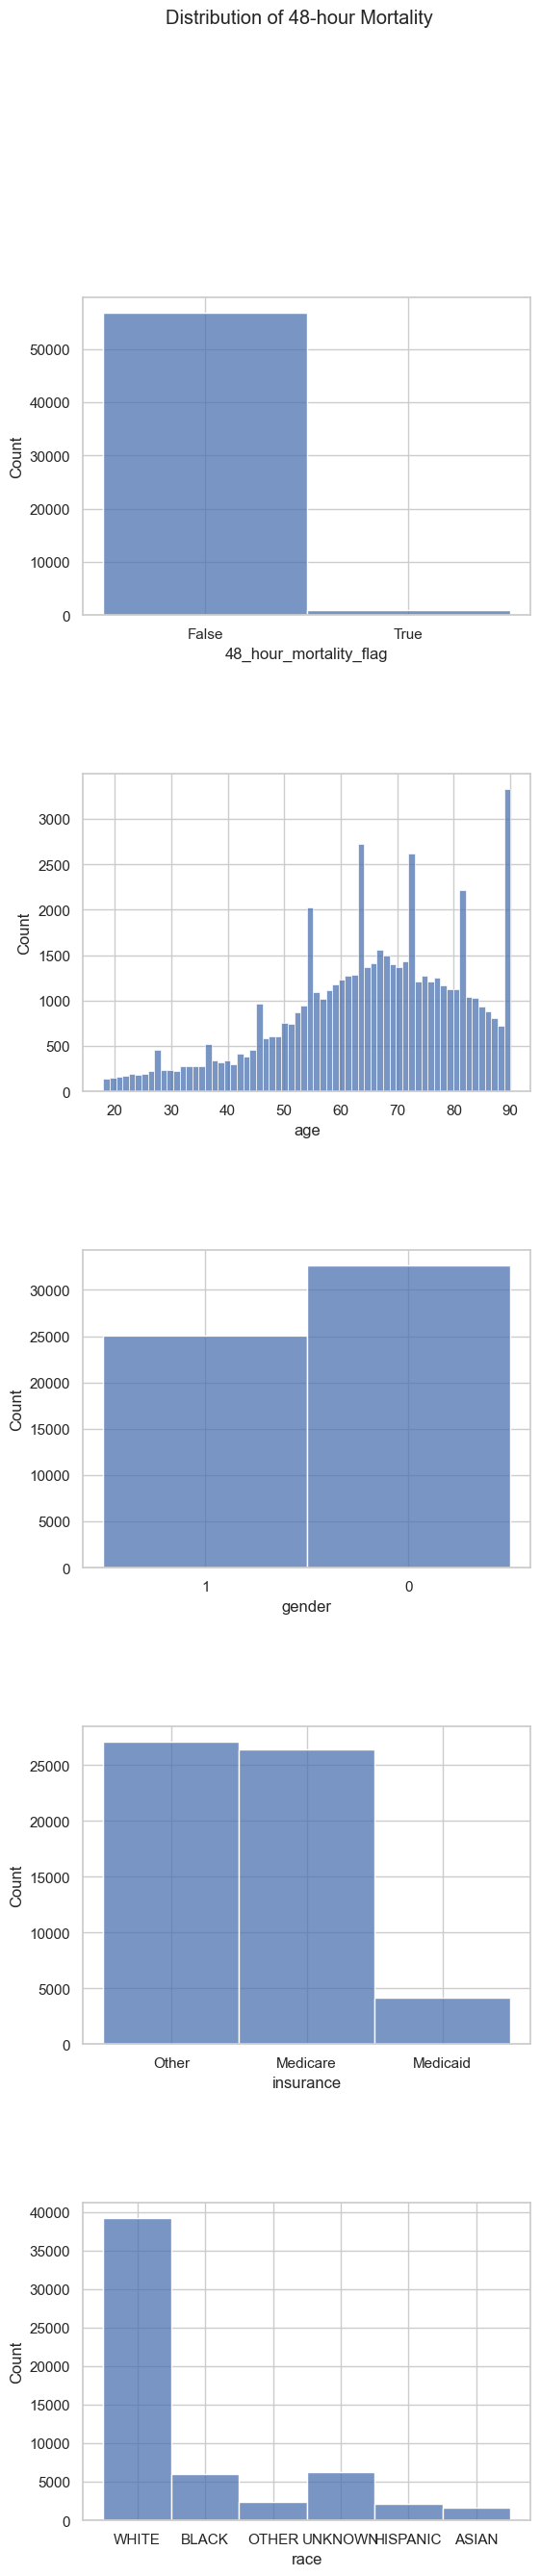

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualizations
sns.set(style="whitegrid")
# suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(6, 30))
fig.suptitle("Distribution of 48-hour Mortality")
dem_feats = ["48_hour_mortality_flag", "age", "gender", "insurance", "race"]
for i, feat in enumerate(dem_feats):
    if feat == "age":
        icustays_df[feat] = icustays_df[feat].astype(int)
        sns.histplot(data=icustays_df, x=feat, ax=axes[i])
        # axes[i].set_xticks(np.arange(0, 100, 10))
        continue
    icustays_df[feat] = icustays_df[feat].astype(str)
    sns.histplot(data=icustays_df, x=feat, ax=axes[i])


# make room between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

## Load vital signs data (chartevents)
- and their definitions (d_items)

In [7]:
if SCRATCH:
    print("Reading in data from scratch")
    # get vitals table (chartevents)
    chartevent_definitions = pd.read_csv(icu_paths["d_items"])
    chartevent_definitions = chartevent_definitions[
        (chartevent_definitions["linksto"] == "chartevents")
        & (chartevent_definitions["category"] == "Routine Vital Signs")
    ]
    routine_vital_items = chartevent_definitions["itemid"].values
    print(f"Number of unique routine vital sign item ids: {len(routine_vital_items)}")

    chartevents = pd.read_csv(icu_paths["chartevents"], chunksize=10000000)
    icu_stay_ids = set(icustays_df["stay_id"])

    for p in [
        os.path.join(".", "data"),
        os.path.join(".", "data", "mimic_chartevents"),
    ]:
        if not os.path.isdir(p):
            os.mkdir(p)

    mimic_chartevents_parent = os.path.join(".", "data", "mimic_chartevents")

    clean_mem(chartevents)

    if len(os.listdir(mimic_chartevents_parent)) == 0:
        for i, chunk in enumerate(chartevents):
            original_size = chunk.shape
            chunk = chunk[
                (chunk["stay_id"].isin(icu_stay_ids))
                & (chunk["itemid"].isin(routine_vital_items))
            ]
            chunk.to_csv(
                os.path.join(mimic_chartevents_parent, f"mimic_vitals_{i}.csv"),
                index=False,
            )
            print(f"Chunk {i}: selected {chunk.shape[0]} from {original_size[0]} rows.")

    chartevents_df = pd.concat(
        [
            pd.read_csv(
                path,
                dtype={
                    "subject_id": np.int32,
                    "hadm_id": np.int32,
                    "stay_id": np.int32,
                    "caregiver_id": np.int32,
                    "charttime": str,
                    "storetime": str,
                    "itemid": np.int32,
                    "value": str,
                    "valuenum": np.float64,
                    "valueuom": "category",
                    "warning": bool,
                },
            )
            for path in get_files_of_type(mimic_chartevents_parent, filetype="csv")
        ],
        axis=0,
        ignore_index=True,
    )
    chartevents_df.reset_index(drop=True, inplace=True)
    chartevents_df = dataframe_datetime(chartevents_df)
    length = chartevents_df.shape[0]

    chartevents_df = pd.merge(
        chartevents_df,
        chartevent_definitions[["itemid", "label"]],
        on="itemid",
        how="left",
    )
    chartevents_df.drop(columns=["caregiver_id"], inplace=True)

    assert length == chartevents_df.shape[0]
else:
    chartevents_df = pd.read_csv(
        os.path.join(SAVEDIR, "data", "chartevents.csv"),
        dtype={
            "subject_id": np.int32,
            "hadm_id": np.int32,
            "stay_id": np.int32,
            "caregiver_id": np.int32,
            "charttime": str,
            "storetime": str,
            "itemid": np.int32,
            "value": str,
            "valuenum": np.float64,
            "valueuom": "category",
            "warning": bool,
        },
    )
print(f"{chartevents_df.shape=}")
chartevents_df = dataframe_datetime(chartevents_df)
chartevents_df.head(1)

Reading in data from scratch
Number of unique routine vital sign item ids: 50
chartevents_df.shape=(40665493, 11)


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label
0,10001217,24597018,37067082,2157-11-21 19:00:00,2157-11-21 19:37:00,220045,101,101.0,bpm,False,Heart Rate


In [8]:
if not os.path.exists(os.path.join(SAVEDIR, "data", "chartevents.csv")):
    chartevents_df.to_csv(os.path.join(SAVEDIR, "data", "chartevents.csv"), index=False)

## Analyze Missingness in chartevents_df

In [9]:
chartevents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40665493 entries, 0 to 40665492
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int32         
 1   hadm_id     int32         
 2   stay_id     int32         
 3   charttime   datetime64[ns]
 4   storetime   datetime64[ns]
 5   itemid      int32         
 6   value       object        
 7   valuenum    float64       
 8   valueuom    category      
 9   warning     bool          
 10  label       object        
dtypes: bool(1), category(1), datetime64[ns](2), float64(1), int32(4), object(2)
memory usage: 2.2+ GB


value       0.105310
valuenum    0.331706
valueuom    0.335364
dtype: float64

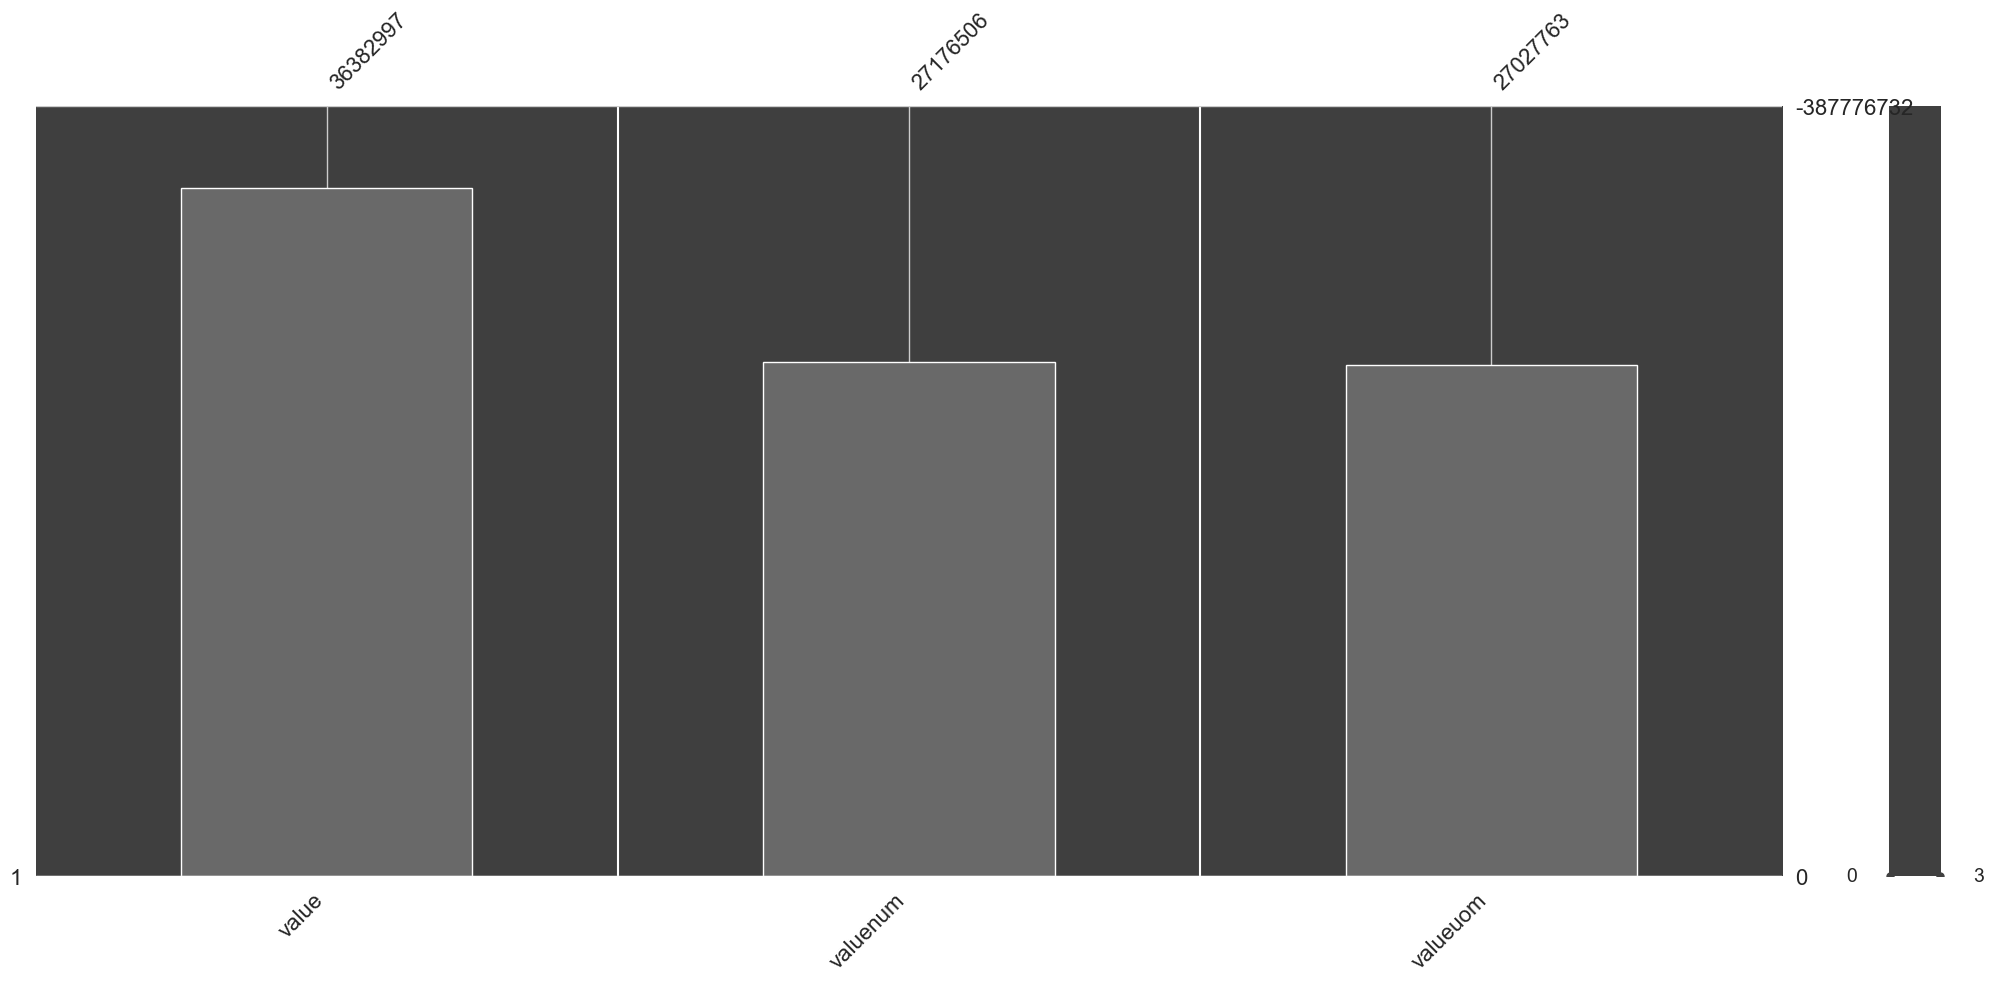

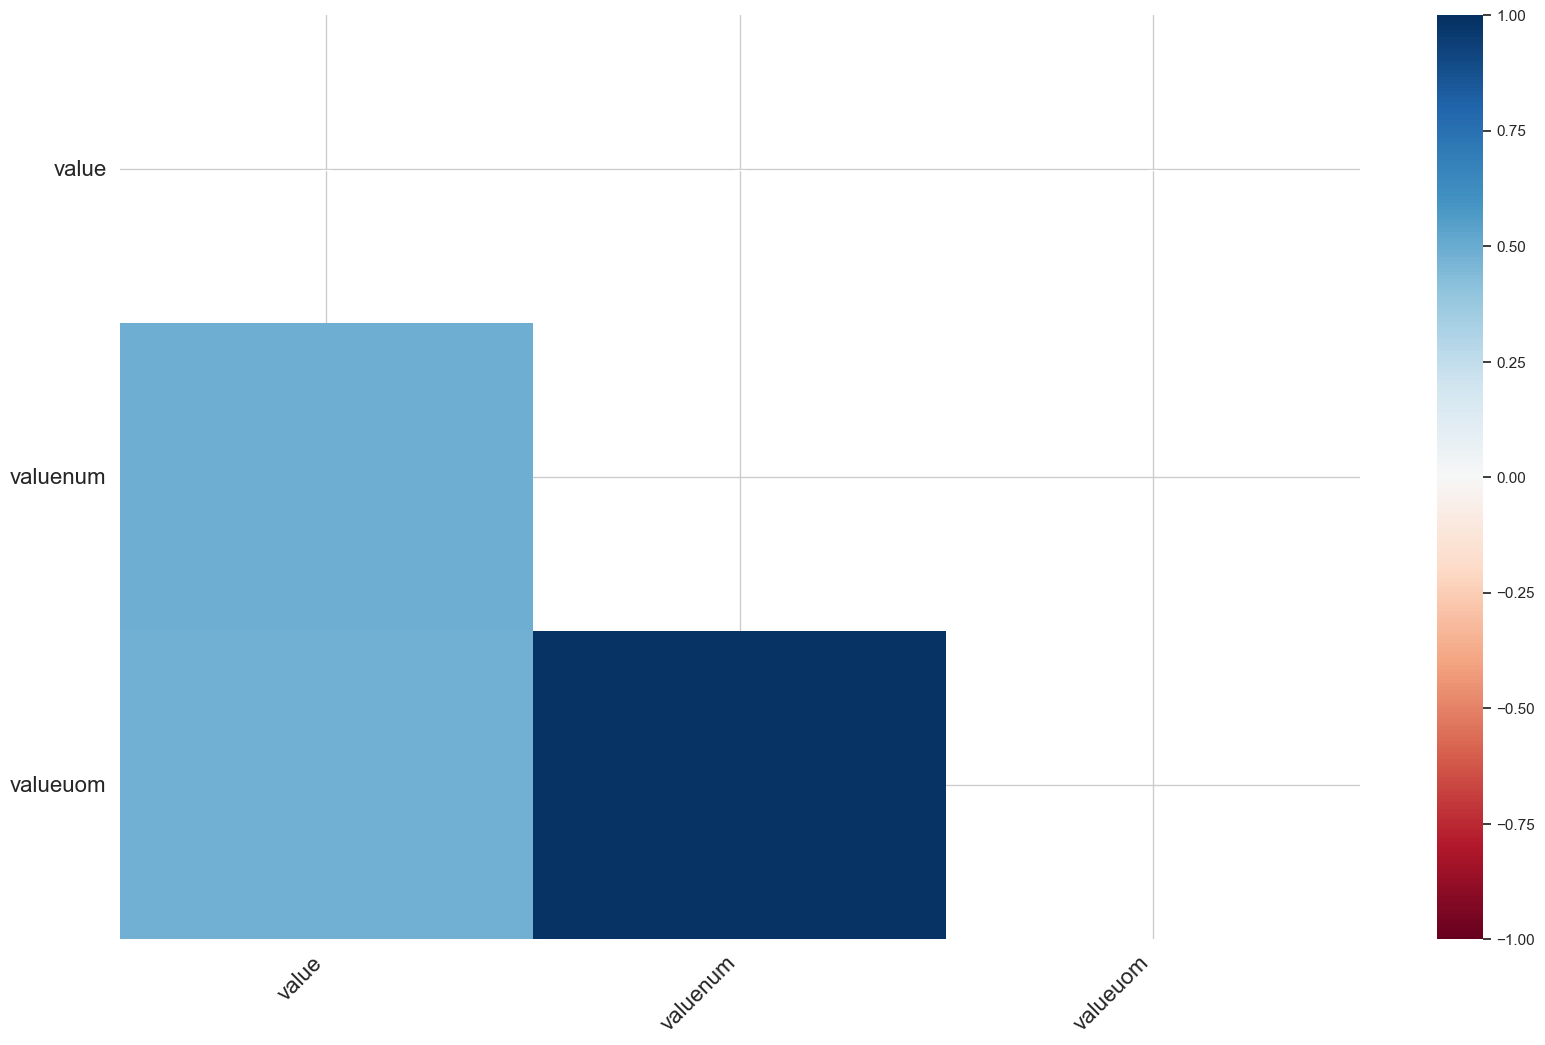

In [10]:
from get_tables import *
try:
    missing_charts = missingness(df=chartevents_df)
except:
    print('')

count    6.179707e+06
mean     8.633857e+01
std      1.841630e+01
min      0.000000e+00
25%      7.300000e+01
50%      8.500000e+01
75%      9.800000e+01
max      2.950000e+02
Name: valuenum, dtype: float64

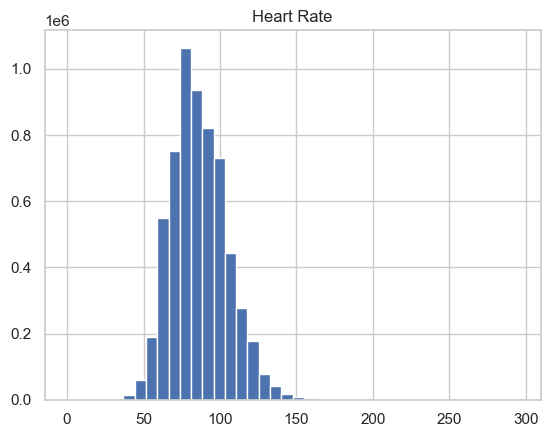

count    3.844922e+06
mean     1.196691e+02
std      2.223590e+01
min      0.000000e+00
25%      1.030000e+02
50%      1.170000e+02
75%      1.340000e+02
max      2.800000e+02
Name: valuenum, dtype: float64

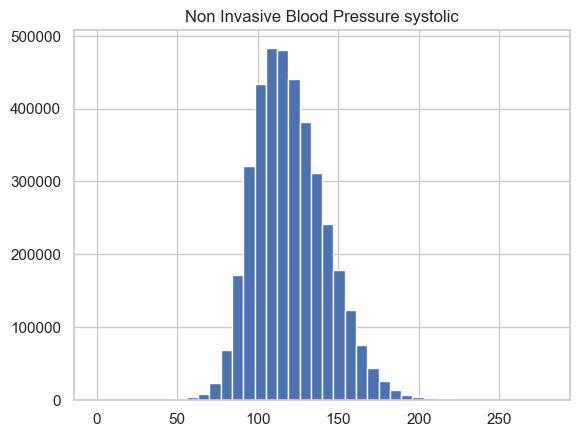

count    3.843863e+06
mean     6.488196e+01
std      1.575905e+01
min      0.000000e+00
25%      5.400000e+01
50%      6.300000e+01
75%      7.400000e+01
max      2.610000e+02
Name: valuenum, dtype: float64

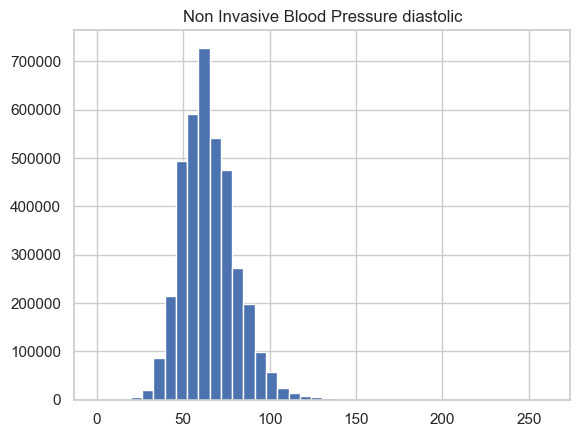

count    3.842253e+06
mean     7.839710e+01
std      1.589315e+01
min      0.000000e+00
25%      6.700000e+01
50%      7.700000e+01
75%      8.800000e+01
max      2.770000e+02
Name: valuenum, dtype: float64

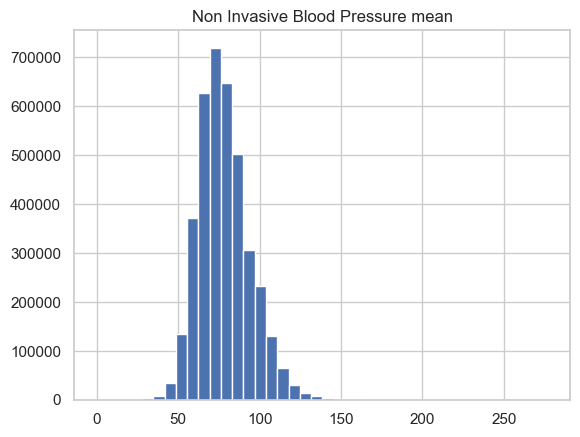

In [11]:
# Visualize histograms for label = 'Heart Rate' and label = 'Non Invasive Blood Pressure systolic' and label = 'Non Invasive Blood Pressure diastolic', and label = 'Non Invasive Blood Pressure mean'

# Set the style of the visualizations
sns.set(style="whitegrid")

# Create subplots
vital_feats = [
    "Heart Rate",
    "Non Invasive Blood Pressure systolic",
    "Non Invasive Blood Pressure diastolic",
    "Non Invasive Blood Pressure mean",
]
# exclude outliers
temp_df = chartevents_df[
    (chartevents_df["valuenum"] >= 0) & (chartevents_df["valuenum"] <= 300)
]
for feat in vital_feats:
    display(temp_df[temp_df["label"] == feat]["valuenum"].describe())
    plt.hist(temp_df[temp_df["label"] == feat]["valuenum"], bins=40)
    plt.title(feat)

    plt.show()


In [12]:
# exclude outliers for vitals
chartevents_df
#exclude negative values
chartevents_df = chartevents_df[chartevents_df['valuenum']>=0]
#exclude values above 300
chartevents_df = chartevents_df[chartevents_df['valuenum']<=300]
chartevents_df.to_csv(os.path.join(SAVEDIR, "data", "chartevents.csv"), index=False)

## Load labs data ()
- and their definitions (d_items)<br>
`labevent_id`: A unique identifier for each laboratory event.<br>
`subject_id`: A unique identifier for each patient.<br>
`hadm_id`: Hospital admission ID, a unique identifier for each hospital stay.<br>
`specimen_id`: A unique identifier for the specimen being tested.<br>
`itemid`: A unique identifier for each item or test conducted.<br>
`order_provider_id`: The ID of the healthcare provider who ordered the test.<br>
`charttime`: The timestamp when the laboratory test result was charted.<br>
`storetime`: The timestamp when the laboratory test result was stored in the database.<br>
`value`: The result of the laboratory test as a string (e.g., "Positive", "Negative", or a numeric value as a string).<br>
`valuenum`: The result of the laboratory test as a number, if applicable.<br>
`valueuom`: The unit of measure for the result (e.g., mg/dL, mmol/L, etc.).<br>
`ref_range_lower`: The lower limit of the reference range for the test result.<br>
`ref_range_upper`: The upper limit of the reference range for the test result.<br>
`flag`: Indicates if the result is abnormal or outside the reference range.<br>
`priority`: The priority of the laboratory test order (e.g., STAT, routine, etc.).<br>
`comments`: Any additional comments or notes related to the laboratory test or result.<br>

In [13]:
labevents_dict = {
    "labevent_id": np.int32,
    "subject_id": np.int32,
    # "hadm_id": np.int32,
    "specimen_id": np.int32,
    "itemid": np.int32,
    "charttime": "str",
    "storetime": "str",
    "value": "str",
    "valuenum": np.float64,
    "valueuom": "str",
    "ref_range_lower": np.float64,
    "ref_range_upper": np.float64,
    "flag": "category",  # change to bool
    "priority": "category",  # change to bool
    "comments": "str",
}
if SCRATCH:
    print("Reading in data from scratch")
    labevents_df = pd.read_csv(
        hosp_paths["labevents"],
        dtype=labevents_dict,
        parse_dates=["charttime", "storetime"],
    )
    labevents_df = labevents_df[labevents_df["subject_id"].isin(subjects)]
    labevents_df = labevents_df[pd.notnull(labevents_df["hadm_id"])]
else:
    labevents_df = pd.read_csv(
        os.path.join(SAVEDIR, "data", "labevents.csv"),
        dtype=labevents_dict,
        parse_dates=["charttime", "storetime"],
    )
labevents_df = dataframe_datetime(labevents_df)
labevents_df.head(1)

Reading in data from scratch


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
8988,9004,10001217,24597018.0,69818655,51790,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.0,mg/dL,NaN,NaN,NaN,ROUTINE,NaN


In [14]:
if not os.path.exists(os.path.join(SAVEDIR, "data", "labevents.csv")):
    labevents_df = labevents_df.to_csv(
        os.path.join(SAVEDIR, "data", "labevents.csv"), index=False
    )

# Analyze Missingness in labevents_df

In [15]:
labevents_df.head(1)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
8988,9004,10001217,24597018.0,69818655,51790,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.0,mg/dL,NaN,NaN,NaN,ROUTINE,NaN


storetime          0.004593
value              0.058285
valuenum           0.088407
valueuom           0.129304
ref_range_lower    0.152776
ref_range_upper    0.152776
comments           0.854265
dtype: float64

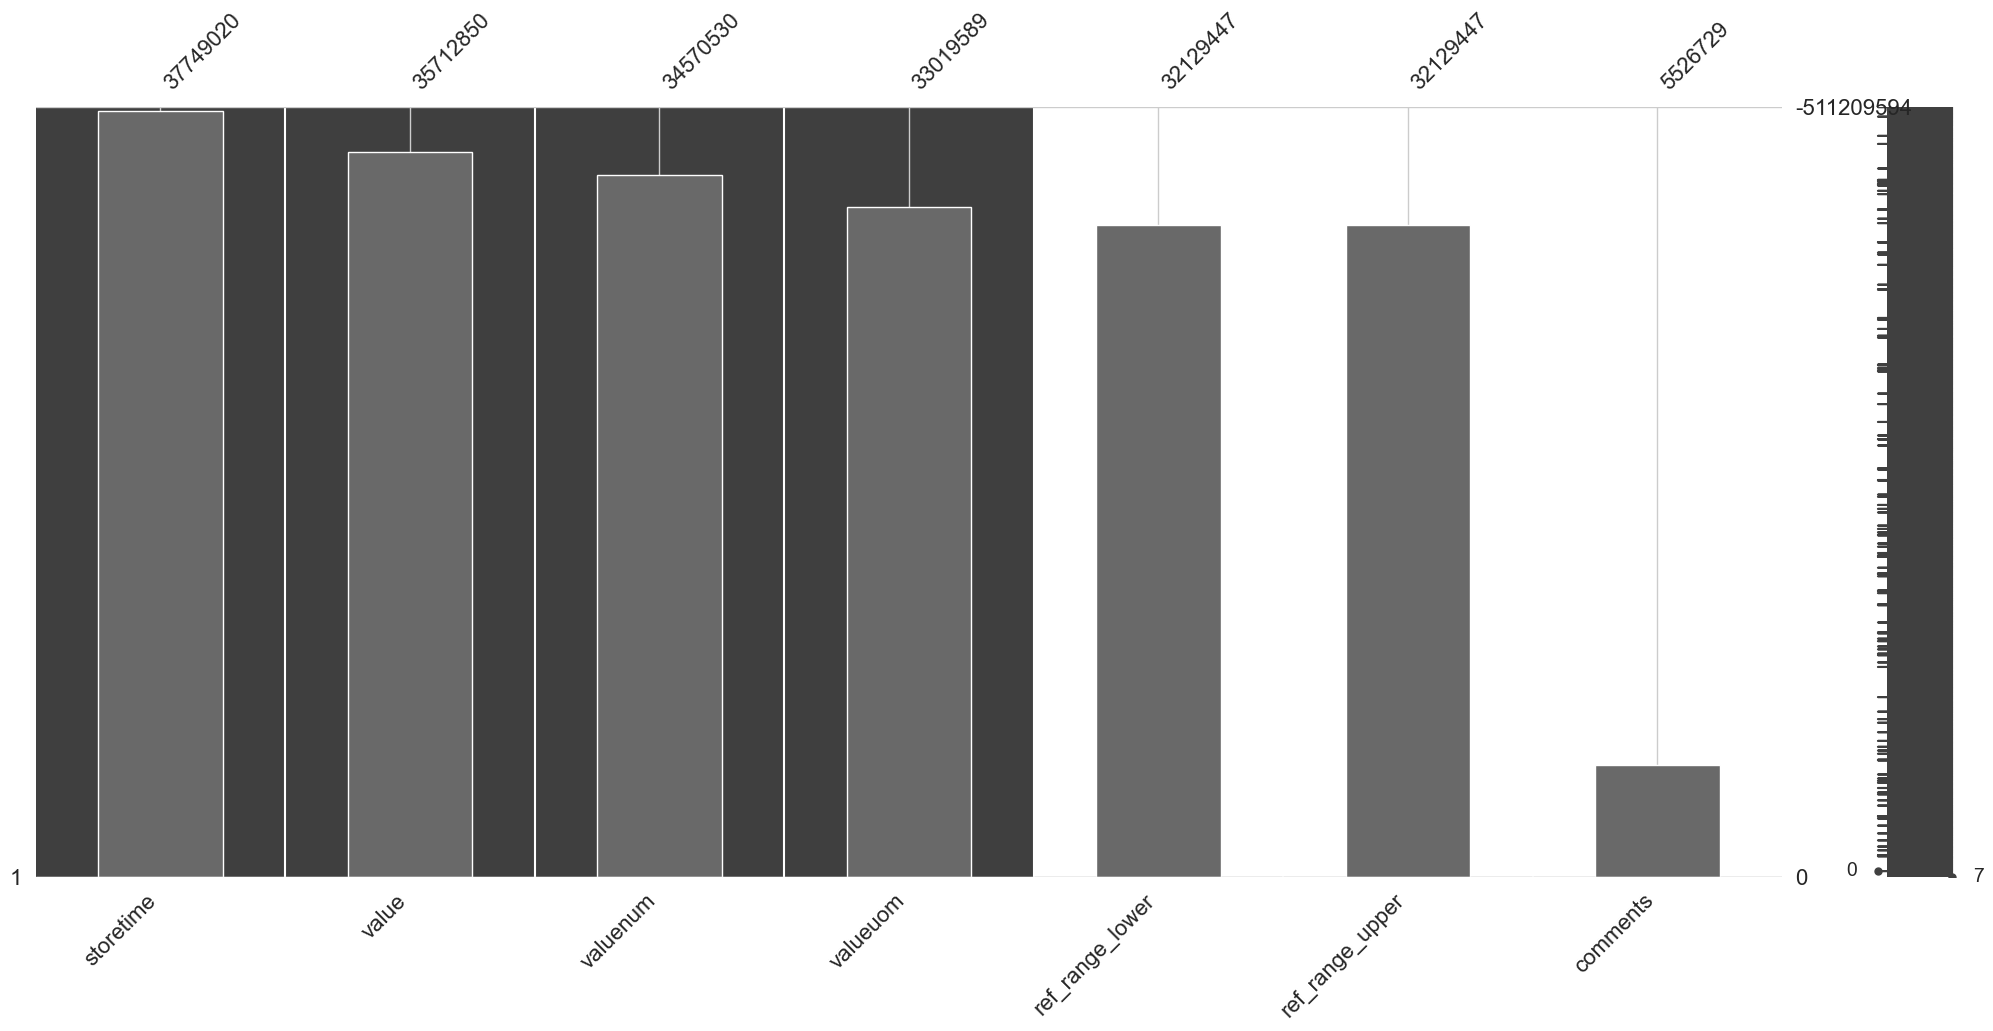

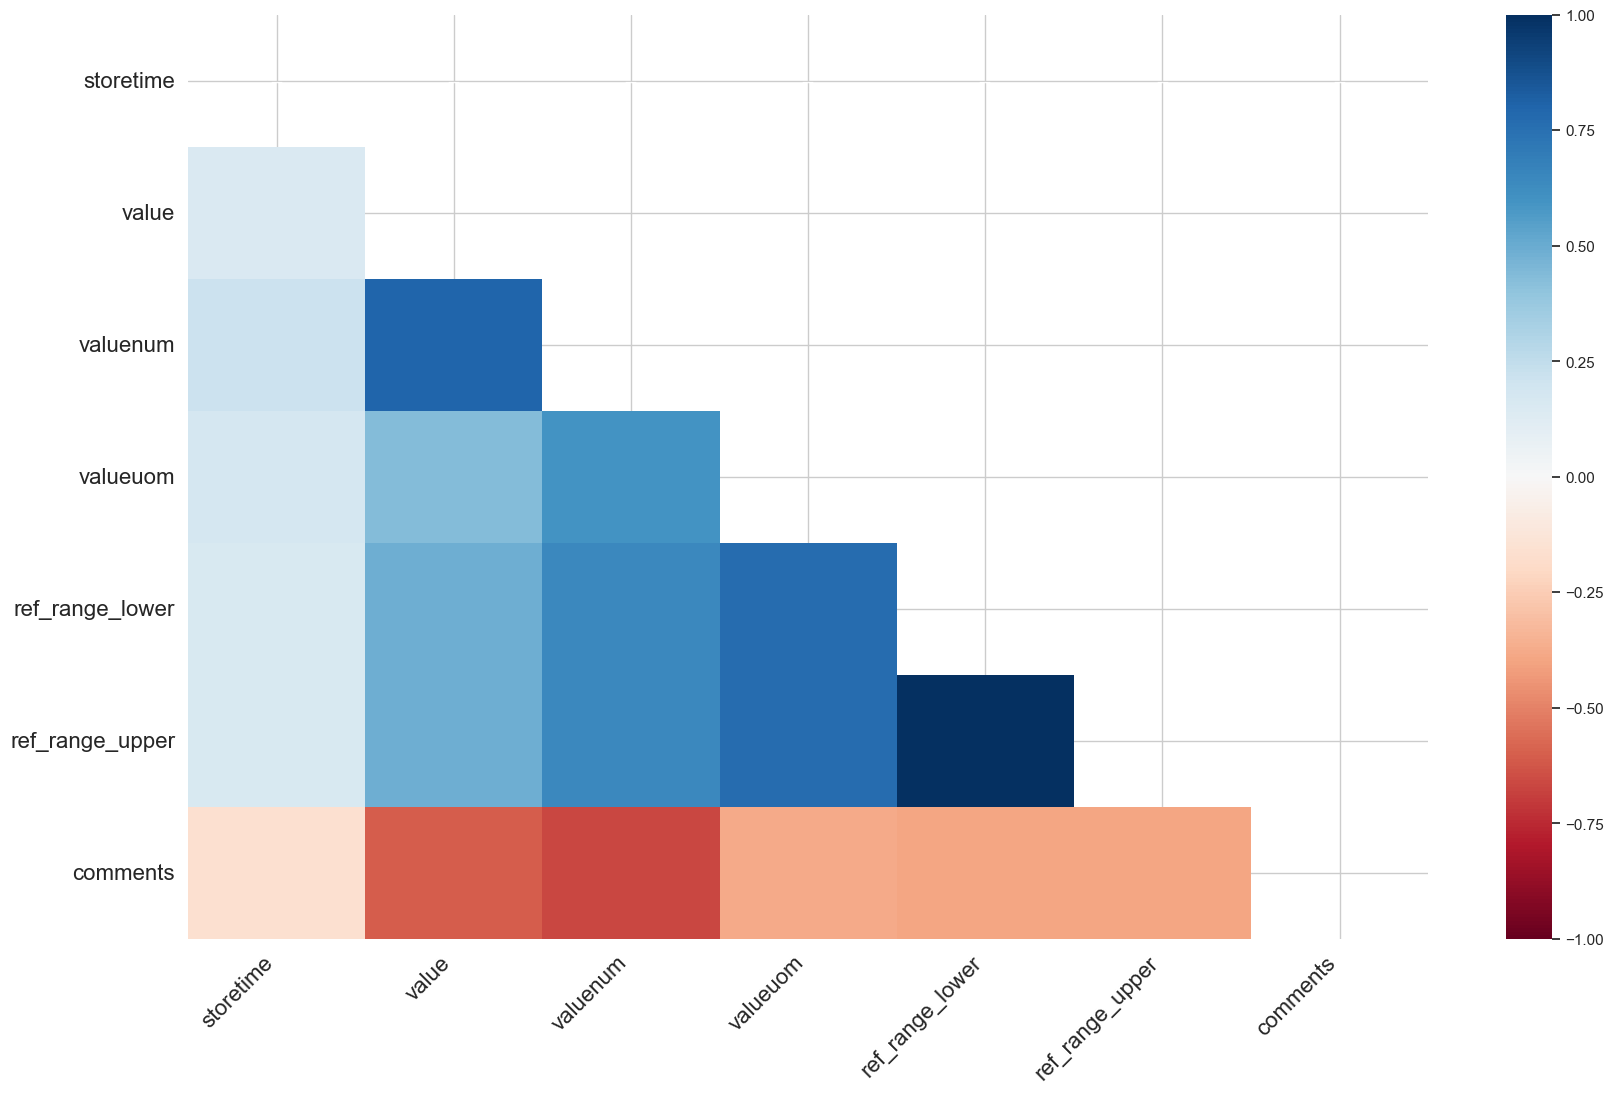

In [16]:
try:
    labevents_df.drop(columns="order_provider_id", inplace=True)
    labevents_df["abnormal"] = labevents_df["flag"].astype("str")
except:
    print("not in axis")
# rename flag column to abnormal, and convert null values to False, "abnormal" to True

labevents_df["abnormal"] = labevents_df["abnormal"].fillna(False)
labevents_df["abnormal"] = labevents_df["abnormal"].replace({"nan": False})
labevents_df["abnormal"] = labevents_df["abnormal"].replace({"abnormal": True})
labevents_df["abnormal"] = labevents_df["abnormal"].astype("bool")
try:
    labevents_df.drop(columns="flag", inplace=True)
except:
    print("not in axis")


labevents_df["priority"] = labevents_df["priority"].astype("str")
labevents_df["priority"] = labevents_df["priority"].replace("STAT", True)
labevents_df["priority"] = labevents_df["priority"].replace("ROUTINE", False)
#labevents_df["priority"] = labevents_df["priority"].astype("bool")


# replace '--' with NaN
labevents_df = labevents_df.replace("--", np.nan)
try:
    missing = missingness(labevents_df)
    missing = missing.index
except:
    print("")

In [17]:
# use comments column to fill in missing values
# if the comments column contains a number, use that as the value
import re
labevents_df["comments"] = labevents_df["comments"].astype("str")
def get_number(string):
    """
    If string is a number, or has a number inside of it, return that number
    """
    #use regex to find number in string
    # the number can include a decimal point
    
    try:
        return re.search(r"[-+]?\d*\.\d+|\d+", string).group()
        
    except:
        return np.nan
    
labevents_df["comments"] = labevents_df["comments"].apply(get_number)
# replace the missing values in valuenum with the comments column
# change the type to float, if it yields a number otherwise it should return a NaN
labevents_df["valuenum"] = labevents_df["valuenum"].fillna(labevents_df["comments"])


labevents_df["valuenum"] = labevents_df["valuenum"].astype("float")


labevents_df.isnull().sum() / labevents_df.shape[0]


labevent_id        0.000000
subject_id         0.000000
hadm_id            0.000000
specimen_id        0.000000
itemid             0.000000
charttime          0.000000
storetime          0.004593
value              0.058285
valuenum           0.074431
valueuom           0.129304
ref_range_lower    0.152776
ref_range_upper    0.152776
priority           0.000000
comments           0.952932
abnormal           0.000000
dtype: float64

In [18]:
# drop comments column
labevents_df.drop(columns="comments", inplace=True)
# drop rows with missing values
#labevents_df.dropna(inplace=True)
labevents_df

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,priority,abnormal
8988,9004,10001217,24597018.0,69818655,51790,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.00,mg/dL,NaN,NaN,False,False
8989,9005,10001217,24597018.0,69818655,51802,2157-11-19 02:37:00,2157-11-19 03:19:00,42,42.00,mg/dL,15.0,45.0,False,False
8990,9006,10001217,24597018.0,74137804,52264,2157-11-19 02:37:00,2157-11-19 04:55:00,___,100.00,%,NaN,NaN,False,False
8991,9007,10001217,24597018.0,74137804,52272,2157-11-19 02:37:00,2157-11-19 04:55:00,0,0.00,%,NaN,NaN,False,False
8992,9008,10001217,24597018.0,74137804,52281,2157-11-19 02:37:00,2157-11-19 04:55:00,___,0.00,%,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118171359,118352498,19999987,23865745.0,85842100,51250,2145-11-09 05:30:00,2145-11-09 07:06:00,104,104.00,fL,82.0,98.0,False,True
118171360,118352499,19999987,23865745.0,85842100,51265,2145-11-09 05:30:00,2145-11-09 07:06:00,129,129.00,K/uL,150.0,440.0,False,True
118171361,118352500,19999987,23865745.0,85842100,51277,2145-11-09 05:30:00,2145-11-09 07:06:00,15.4,15.40,%,10.5,15.5,False,False
118171362,118352501,19999987,23865745.0,85842100,51279,2145-11-09 05:30:00,2145-11-09 07:06:00,3.52,3.52,m/uL,4.2,5.4,False,True


In [19]:
labevents_df['priority'].value_counts(dropna=False)

priority
True     17538841
False    16034624
nan       4349738
Name: count, dtype: int64

In [28]:
labevents_df.reset_index(drop=True, inplace=True)
# merge labevents_df with labevent_definitions to get the label for each itemid
labevent_definitions = pd.read_csv(icu_paths["d_items"])
labevents_df = pd.merge(
    labevents_df,
    labevent_definitions[["itemid", "label"]],
    on="itemid",
    how="left",
)



MemoryError: 

In [ ]:
#Visualize for labevents_df
#make histograms for the 

# Split into 80% train, and 20% test set

In [29]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# 80% train, 20% test
# icustays_df = icustays_df.sort_values(by="intime")


# split chronologically, sine we cannot have a patient in the test set who has an earlier stay number in the train set
train_ids, test_ids = train_test_split(
    icustays_df["subject_id"], test_size=0.2, shuffle=True
)
icustays_df["data_split"] = icustays_df["subject_id"].isin(train_ids)
icustays_df["data_split"] = icustays_df["data_split"].replace(
    {True: "train", False: "test"}
)
icustays_df.to_csv(
    os.path.join(SAVEDIR, "data", "mimic_subject_split.csv"), index=False
)
print(icustays_df.shape)
icustays_df.head(1)

(57734, 16)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,deathtime,48_hour_mortality_flag,age,gender,race,insurance,data_split
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,NaT,False,55,1,WHITE,Other,train


In [103]:
table_one = icustays_df[['48_hour_mortality_flag','race', 'age', 'insurance', 'gender', 'stay_id', 'hadm_id', 'subject_id']]
table_one

,48_hour_mortality_flag,race,age,insurance,gender,stay_id,hadm_id,subject_id
0,False,WHITE,55,Other,1,37067082,24597018,10001217
1,False,WHITE,46,Other,1,31205490,25563031,10001725
2,False,BLACK,77,Medicare,1,37510196,26184834,10001884
3,False,OTHER,57,Medicare,1,39060235,23581541,10002013
4,False,WHITE,81,Other,1,33685454,23822395,10002155
...,...,...,...,...,...,...,...,...
57729,False,OTHER,42,Other,0,37364566,21439025,19999297
57730,False,WHITE,43,Medicaid,0,32336619,26785317,19999442
57731,False,WHITE,48,Other,1,36075953,25744818,19999828
57732,False,WHITE,58,Other,0,38978960,21033226,19999840


In [104]:
def describe_continuous(series):
    mean = series.mean()
    std = series.std()
    return f"{mean:.2f} ({std:.2f})"

def describe_categorical(series):
    counts = series.value_counts()
    total = len(series)
    descriptions = [f"{val} ({count/total*100:.1f}%)" for val, count in counts.items()]
    return ", ".join(descriptions)

def create_table_1(df, stratify_var):
    # Define variables
    continuous_vars = ['age']
    categorical_vars = ['gender', 'race', 'insurance', 'hadm_id', 'stay_id']
    
    # Define stratified columns
    strata = df[stratify_var].unique()
    strata_labels = [f"{stratify_var}: {s}" for s in strata]
    columns = ["Overall"] + strata_labels
    
    # Initialize Table 1
    table_1 = pd.DataFrame(index=["N"] + continuous_vars + categorical_vars, columns=columns)
    
    # Overall statistics
    table_1.loc["N", "Overall"] = len(df)
    for var in continuous_vars:
        table_1.loc[var, "Overall"] = describe_continuous(df[var])
    for var in categorical_vars:
        table_1.loc[var, "Overall"] = describe_categorical(df[var])
    
    # Stratified statistics
    for stratum, label in zip(strata, strata_labels):
        strata_data = df[df[stratify_var] == stratum]
        table_1.loc["N", label] = len(strata_data)
        for var in continuous_vars:
            table_1.loc[var, label] = describe_continuous(strata_data[var])
        for var in categorical_vars:
            table_1.loc[var, label] = describe_categorical(strata_data[var])
    
    return table_1
#convert boolean gender to Female = 1
#table_one.gender = table_one.gender.map({'F':True, 'M':False})
#display(table_one.gender.value_counts())
create_table_1(table_one, '48_hour_mortality_flag')

,Overall,48_hour_mortality_flag: False,48_hour_mortality_flag: True
N,57734,56818,916
age,65.00 (16.34),64.90 (16.34),71.19 (15.26)
gender,"0 (56.5%), 1 (43.5%)","0 (56.6%), 1 (43.4%)","0 (52.0%), 1 (48.0%)"
race,"WHITE (67.9%), UNKNOWN (10.9%), BLACK (10.4%),...","WHITE (68.0%), UNKNOWN (10.7%), BLACK (10.5%),...","WHITE (61.0%), UNKNOWN (21.2%), BLACK (8.4%), ..."
insurance,"Other (46.9%), Medicare (45.8%), Medicaid (7.3%)","Other (47.1%), Medicare (45.7%), Medicaid (7.3%)","Medicare (55.0%), Other (39.4%), Medicaid (5.6%)"
hadm_id,"23344494 (0.0%), 24307798 (0.0%), 26879479 (0....","23344494 (0.0%), 26543049 (0.0%), 26879479 (0....","22942076 (0.1%), 29846851 (0.1%), 21548105 (0...."
stay_id,"37067082 (0.0%), 39993968 (0.0%), 35755099 (0....","37067082 (0.0%), 34427349 (0.0%), 31445224 (0....","34617352 (0.1%), 38649297 (0.1%), 36943198 (0...."


In [105]:
table_one = table_one.groupby(['subject_id', '48_hour_mortality_flag']).size()
table_one = table_one.reset_index()
#table_one[table_one['48_hour_mortality_flag']==False]
table_one

,subject_id,48_hour_mortality_flag,0
0,10001217,False,1
1,10001725,False,1
2,10001884,False,1
3,10002013,False,1
4,10002155,False,2
...,...,...,...
42497,19999297,False,1
42498,19999442,False,1
42499,19999828,False,1
42500,19999840,False,1


In [30]:
# TO-DO: MAKE YOUR OWN SPLITS FOR MIMIC_SUBJECT_SPLIT

# Get train subjects and test subjects
split_df_path = os.path.join(".", "data", "mimic_subject_split.csv")
split_df = pd.read_csv(split_df_path)
train_subjects, test_subjects = (
    split_df[split_df["data_split"] == "train"]["subject_id"].values,
    split_df[split_df["data_split"] == "test"]["subject_id"].values,
)
assert set(train_subjects) & set(test_subjects) == set()

train_stay_ids = icustays_df[icustays_df["subject_id"].isin(train_subjects)][
    "stay_id"
].values

In [32]:
if SCRATCH:
    lab_itemids = itemids_with_minimum_uid_counts(
        labevents_df[labevents_df["subject_id"].isin(train_subjects)],
        uid_column="subject_id",
        key_column="itemid",
        MIN_UID_THRESHOLD=0.9,
    )
    chartevents_itemids = itemids_with_minimum_uid_counts(
        chartevents_df[chartevents_df["stay_id"].isin(train_stay_ids)],
        uid_column="stay_id",
        key_column="itemid",
        MIN_UID_THRESHOLD=0.9,
    )

    labevents_df = labevents_df[labevents_df["itemid"].isin(lab_itemids)]
    labevents_df.to_csv(os.path.join(SAVEDIR, "data", "labevents.csv"), index=False)
    chartevents_df = chartevents_df[chartevents_df["itemid"].isin(chartevents_itemids)]
    chartevents_df.to_csv(os.path.join(SAVEDIR, "data", "chartevents.csv"), index=False)

In [33]:
icustays_df = icustays_df.drop(columns=["first_careunit", "last_careunit"])
icustays_df.head(1)

,subject_id,hadm_id,stay_id,intime,outtime,los,admittime,deathtime,48_hour_mortality_flag,age,gender,race,insurance,data_split
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,NaT,False,55,1,WHITE,Other,train


In [34]:
def get_feature_dict_from_dataframe(df, uid, uid_column, intime, time_column, key_column, value_column) :

    first_24_hours = (intime, intime + pd.DateOffset(hours = 24))
    current_df = df[df[uid_column] == uid].copy()
    current_df = current_df[current_df[time_column].between(*first_24_hours)]
    current_df[value_column] = pd.to_numeric(current_df[value_column], errors = 'coerce')
    current_df = current_df[pd.notnull(current_df[value_column])]
    current_df = current_df[[key_column, value_column]].groupby([key_column]).agg(np.mean).reset_index() #value_column = 'valuenum', key_column = 'itemid'
    return dict(zip(current_df[key_column], current_df[value_column]))

In [36]:
# only feed in the columns that we need for chartevents and labevents
chartevents_min_df = pd.read_csv(
    os.path.join(SAVEDIR, "data", "chartevents.csv"),
    usecols=["stay_id", "charttime", "itemid", "valuenum", 'warning'],
    dtype={
        "stay_id": np.int32,
        "charttime": str,
        "itemid": np.int32,
        "valuenum": np.float64,
    },
    parse_dates=["charttime"],
)
labevents_min_df = pd.read_csv(
    os.path.join(SAVEDIR, "data", "labevents.csv"),
    usecols=["subject_id", "charttime", "itemid", "valuenum", 'priority', 'abnormal'],
    dtype={
        "stay_id": np.int32,
        "charttime": str,
        "itemid": np.int32,
        "valuenum": np.float64,
    },
    parse_dates=["charttime"],
)
icustays = pd.read_csv(
    os.path.join(SAVEDIR, "data", "icustays.csv"),
    usecols=["stay_id", "intime", "subject_id"],
    dtype={"stay_id": np.int32, "intime": str, "subject_id": np.int32},
    parse_dates=["intime"],
)

In [ ]:
labevents_min_df.size

95518724

In [37]:
from tqdm import tqdm

icustays_dicts = icustays.to_dict("records")
icustays_dicts = np.array_split(icustays_dicts, 10)

processed_parent_path = os.path.join(".", "data", "mimic_processed2")
if not os.path.isdir(processed_parent_path):
    os.mkdir(processed_parent_path)

if len(os.listdir(processed_parent_path)) == 0:
    for i, icu_stay_dict_array in enumerate(icustays_dicts):
        data = {}

        for _, icustay_dict in tqdm(enumerate(icu_stay_dict_array)):
            
            vital_features = get_feature_dict_from_dataframe(
                df=chartevents_min_df,
                uid=icustay_dict["stay_id"],
                uid_column="stay_id",
                intime=icustay_dict["intime"],
                time_column="charttime",
                key_column="itemid",
                value_column="valuenum",
            )
            lab_features = get_feature_dict_from_dataframe(
                df=labevents_min_df,
                uid=icustay_dict["subject_id"],
                uid_column="subject_id",
                intime=icustay_dict["intime"],
                time_column="charttime",
                key_column="itemid",
                value_column="valuenum",
            )
            lab_priority = get_feature_dict_from_dataframe(
                df=labevents_min_df,
                uid=icustay_dict["subject_id"],
                uid_column="subject_id",
                intime=icustay_dict["intime"],
                time_column="charttime",
                key_column="itemid",
                value_column="priority",
            )
            vital_warning = get_feature_dict_from_dataframe(
                df=chartevents_min_df,
                uid=icustay_dict["stay_id"],
                uid_column="stay_id",
                intime=icustay_dict["intime"],
                time_column="charttime",
                key_column="itemid",
                value_column="warning",
            )
            lab_abnormal = get_feature_dict_from_dataframe(
                df=labevents_min_df,
                uid=icustay_dict["subject_id"],
                uid_column="subject_id",
                intime=icustay_dict["intime"],
                time_column="charttime",
                key_column="itemid",
                value_column="abnormal",
            )
            # print(vital_features)
            vital_features = {f"vital_{k}": v for k, v in vital_features.items()}
            lab_features = {f"lab_{k}": v for k, v in lab_features.items()}
            lab_priority = {f"lab_priority_{k}": v for k, v in lab_priority.items()}
            vital_warning = {f"vital_warning_{k}": v for k, v in vital_warning.items()}
            lab_abnormal = {f"lab_abnormal_{k}": v for k, v in lab_abnormal.items()}
            data[icustay_dict["stay_id"]] = {
                **icustay_dict,
                **vital_features,
                **lab_features,
                **lab_priority,
                **vital_warning,
                **lab_abnormal,
            }

        with open(
            os.path.join(processed_parent_path, f"processed_mimic_{i}.pickle"), "wb"
        ) as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # data = pd.DataFrame(data)
        # data.to_csv(os.path.join(processed_parent_path, f'processed_mimic_{i}.csv'), index = False)
        print(f"{i}: Dict with {len(data)} stay_ids saved.")


data = {}

for pickle_path in get_files_of_type(processed_parent_path, filetype="pickle"):
    with open(pickle_path, "rb") as handle:
        current_data = pickle.load(handle)

    data = {**data, **current_data}

len(data)

5774it [09:29, 10.14it/s]


0: Dict with 5774 stay_ids saved.


5774it [09:28, 10.16it/s]


1: Dict with 5774 stay_ids saved.


5774it [09:28, 10.16it/s]


2: Dict with 5774 stay_ids saved.


5774it [09:28, 10.16it/s]


3: Dict with 5774 stay_ids saved.


5773it [10:29,  9.17it/s]


4: Dict with 5773 stay_ids saved.


5773it [11:05,  8.68it/s]


5: Dict with 5773 stay_ids saved.


5773it [10:17,  9.35it/s]


6: Dict with 5773 stay_ids saved.


5773it [10:02,  9.59it/s]


7: Dict with 5773 stay_ids saved.


5773it [09:29, 10.14it/s]


8: Dict with 5773 stay_ids saved.


5773it [09:29, 10.14it/s]


9: Dict with 5773 stay_ids saved.


57734

In [54]:
data = {}

for pickle_path in get_files_of_type(processed_parent_path, filetype="pickle"):
    with open(pickle_path, "rb") as handle:
        current_data = pickle.load(handle)

    data = {**data, **current_data}

print(len(data))

57734


In [55]:
data = pd.DataFrame(data).T
print(data.shape)
data.reset_index(inplace=True, drop=True)
display(data.head(1))

(57734, 82)


,subject_id,stay_id,intime,vital_220045,vital_220179,vital_220180,vital_220181,vital_223761,lab_50868,lab_50882,...,lab_abnormal_51237,lab_abnormal_51248,lab_abnormal_51249,lab_abnormal_51250,lab_abnormal_51265,lab_abnormal_51274,lab_abnormal_51275,lab_abnormal_51277,lab_abnormal_51279,lab_abnormal_51301
0,10001217,37067082,2157-11-20 19:18:02,93.2,135.32,80.96,93.041667,99.0625,15.0,23.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [56]:
data = data.merge(icustays_df, on=['subject_id',"stay_id"], how="left")

data.head(1)

,subject_id,stay_id,intime_x,vital_220045,vital_220179,vital_220180,vital_220181,vital_223761,lab_50868,lab_50882,...,outtime,los,admittime,deathtime,48_hour_mortality_flag,age,gender,race,insurance,data_split
0,10001217,37067082,2157-11-20 19:18:02,93.2,135.32,80.96,93.041667,99.0625,15.0,23.0,...,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,NaT,False,55,1,WHITE,Other,train


In [57]:
data.columns

Index(['subject_id', 'stay_id', 'intime_x', 'vital_220045', 'vital_220179',
       'vital_220180', 'vital_220181', 'vital_223761', 'lab_50868',
       'lab_50882', 'lab_50893', 'lab_50902', 'lab_50912', 'lab_50931',
       'lab_50960', 'lab_50970', 'lab_50971', 'lab_50983', 'lab_51006',
       'lab_51221', 'lab_51222', 'lab_51237', 'lab_51248', 'lab_51249',
       'lab_51250', 'lab_51265', 'lab_51274', 'lab_51275', 'lab_51277',
       'lab_51279', 'lab_51301', 'lab_priority_50868', 'lab_priority_50882',
       'lab_priority_50893', 'lab_priority_50902', 'lab_priority_50912',
       'lab_priority_50931', 'lab_priority_50960', 'lab_priority_50970',
       'lab_priority_50971', 'lab_priority_50983', 'lab_priority_51006',
       'lab_priority_51221', 'lab_priority_51222', 'lab_priority_51237',
       'lab_priority_51248', 'lab_priority_51249', 'lab_priority_51250',
       'lab_priority_51265', 'lab_priority_51274', 'lab_priority_51275',
       'lab_priority_51277', 'lab_priority_51279', 'l

In [58]:
data = data.drop(columns=["intime_x", 'outtime', 'admittime', 'intime_y', 'deathtime', 'admittime', 'los'])
data = pd.get_dummies(data,columns=['race', 'insurance'])


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57734 entries, 0 to 57733
Data columns (total 95 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subject_id              57734 non-null  object
 1   stay_id                 57734 non-null  object
 2   vital_220045            57664 non-null  object
 3   vital_220179            52084 non-null  object
 4   vital_220180            52077 non-null  object
 5   vital_220181            52084 non-null  object
 6   vital_223761            53568 non-null  object
 7   lab_50868               56832 non-null  object
 8   lab_50882               56901 non-null  object
 9   lab_50893               52254 non-null  object
 10  lab_50902               56929 non-null  object
 11  lab_50912               56920 non-null  object
 12  lab_50931               56658 non-null  object
 13  lab_50960               54840 non-null  object
 14  lab_50970               52417 non-null  object
 15  la

In [60]:
data['48_hour_mortality_flag'] = data['48_hour_mortality_flag'] == 'True'
data['48_hour_mortality_flag'].value_counts()

48_hour_mortality_flag
False    56818
True       916
Name: count, dtype: int64

In [61]:
#if column is bool, change to int
for col in data.columns:
    if data[col].dtype == bool:
        data[col] = data[col].astype(np.int32)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57734 entries, 0 to 57733
Data columns (total 95 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subject_id              57734 non-null  object
 1   stay_id                 57734 non-null  object
 2   vital_220045            57664 non-null  object
 3   vital_220179            52084 non-null  object
 4   vital_220180            52077 non-null  object
 5   vital_220181            52084 non-null  object
 6   vital_223761            53568 non-null  object
 7   lab_50868               56832 non-null  object
 8   lab_50882               56901 non-null  object
 9   lab_50893               52254 non-null  object
 10  lab_50902               56929 non-null  object
 11  lab_50912               56920 non-null  object
 12  lab_50931               56658 non-null  object
 13  lab_50960               54840 non-null  object
 14  lab_50970               52417 non-null  object
 15  la

In [ ]:
data['train'] = data['data_split'] == 'train'

In [62]:
data['gender'] = data['gender'] == '1'

In [63]:
data.to_csv(os.path.join(SAVEDIR, "data", "mimic_subject_split.csv"), index=False)

# Train XGBoost Model

['vital_220045', 'vital_220179', 'vital_220180', 'vital_220181', 'vital_223761', 'lab_50868', 'lab_50882', 'lab_50893', 'lab_50902', 'lab_50912', 'lab_50931', 'lab_50960', 'lab_50970', 'lab_50971', 'lab_50983', 'lab_51006', 'lab_51221', 'lab_51222', 'lab_51237', 'lab_51248', 'lab_51249', 'lab_51250', 'lab_51265', 'lab_51274', 'lab_51275', 'lab_51277', 'lab_51279', 'lab_51301', 'lab_priority_50868', 'lab_priority_50882', 'lab_priority_50893', 'lab_priority_50902', 'lab_priority_50912', 'lab_priority_50931', 'lab_priority_50960', 'lab_priority_50970', 'lab_priority_50971', 'lab_priority_50983', 'lab_priority_51006', 'lab_priority_51221', 'lab_priority_51222', 'lab_priority_51237', 'lab_priority_51248', 'lab_priority_51249', 'lab_priority_51250', 'lab_priority_51265', 'lab_priority_51274', 'lab_priority_51275', 'lab_priority_51277', 'lab_priority_51279', 'lab_priority_51301', 'vital_warning_220045', 'vital_warning_220179', 'vital_warning_220180', 'vital_warning_220181', 'vital_warning_223

array([[ 0.93709829, -0.21062632, -0.41861132, ..., -0.34003848,
        -0.19687319, -0.20931682],
       [-0.31269483, -0.21062632, -0.41861132, ..., -0.34003848,
        -0.19687319, -0.20931682],
       [ 0.93709829,         nan, -0.41861132, ..., -0.34003848,
        -0.19687319, -0.20931682],
       ...,
       [ 0.93709829, -0.21062632, -0.41861132, ..., -0.34003848,
        -0.19687319, -0.20931682],
       [-0.31269483, -0.21062632, -0.41861132, ..., -0.34003848,
        -0.19687319, -0.20931682],
       [-1.56248795, -0.21062632, -0.41861132, ...,  2.9408436 ,
        -0.19687319, -0.20931682]])

[0]	validation_0-logloss:0.68426
[1]	validation_0-logloss:0.67555
[2]	validation_0-logloss:0.66701
[3]	validation_0-logloss:0.65865
[4]	validation_0-logloss:0.65044
[5]	validation_0-logloss:0.64238
[6]	validation_0-logloss:0.63448
[7]	validation_0-logloss:0.62671
[8]	validation_0-logloss:0.61908
[9]	validation_0-logloss:0.61159
[10]	validation_0-logloss:0.60427
[11]	validation_0-logloss:0.59707
[12]	validation_0-logloss:0.58998
[13]	validation_0-logloss:0.58301
[14]	validation_0-logloss:0.57616
[15]	validation_0-logloss:0.56944
[16]	validation_0-logloss:0.56282
[17]	validation_0-logloss:0.55636
[18]	validation_0-logloss:0.54997
[19]	validation_0-logloss:0.54368
[20]	validation_0-logloss:0.53750
[21]	validation_0-logloss:0.53143
[22]	validation_0-logloss:0.52541
[23]	validation_0-logloss:0.51953
[24]	validation_0-logloss:0.51375
[25]	validation_0-logloss:0.50806
[26]	validation_0-logloss:0.50246
[27]	validation_0-logloss:0.49693
[28]	validation_0-logloss:0.49153
[29]	validation_0-loglos

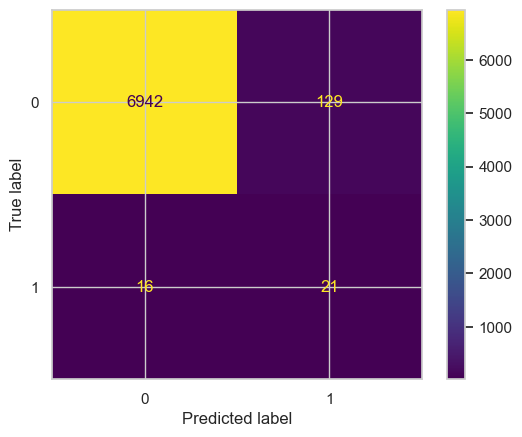

In [64]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
    KFold
)



from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

split_df_path = os.path.join(SAVEDIR, "data", "mimic_subject_split.csv")
split_df = pd.read_csv(split_df_path)
train_subjects, test_subjects = (
    split_df[split_df["data_split"] == "train"]["subject_id"].values,
    split_df[split_df["data_split"] == "test"]["subject_id"].values,
)
assert set(train_subjects) & set(test_subjects) == set()



feature_columns = [
    c for c in data.columns if c not in (set(icustays_df.columns) - {'age', 'gender', 'race'})
]
#feature_columns.remove('data_split')

print(feature_columns)
X_train, y_train = data[data["subject_id"].isin(train_subjects)][
    feature_columns
], data[data["subject_id"].isin(train_subjects)][
    "48_hour_mortality_flag"
].values.astype(
    int
)
X_test, y_test = data[data["subject_id"].isin(test_subjects)][
    feature_columns
].values, data[data["subject_id"].isin(test_subjects)][
    "48_hour_mortality_flag"
].values.astype(
    int
)
# find strings in X_train
for i, col in enumerate(feature_columns):
    if isinstance(X_train.loc[0][i], str):
        print(col)
        print(X_train.loc[0][i])
print(X_train.columns)

MISSINGNESS_THRESHOLD = 0.2
passes_missingness_threhsold = (
    data.isnull().sum() / data.shape[0] <= MISSINGNESS_THRESHOLD
)
feature_columns = list(
    set(passes_missingness_threhsold[passes_missingness_threhsold].index.values)
    - {"48_hour_mortality_flag", "subject_id", "hadm_id", "stay_id"}
)
feature_columns.remove('data_split')
print(feature_columns)
X_train, y_train = data[data["subject_id"].isin(train_subjects)][
    feature_columns
].values, data[data["subject_id"].isin(train_subjects)][
    "48_hour_mortality_flag"
].values.astype(
    int
)
X_test, y_test = data[data["subject_id"].isin(test_subjects)][
    feature_columns
].values, data[data["subject_id"].isin(test_subjects)][
    "48_hour_mortality_flag"
].values.astype(
    int
)


def prc_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)


scaler = StandardScaler()
scaler.fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_train)
xgb = XGBClassifier(
    tree_method="hist",
    early_stopping_rounds=100,
    scale_pos_weight=sum(y_train == 0) / sum(y_train),
    use_label_encoder=False,
    learning_rate=0.01,
    n_estimators=1000,
    device="cuda",
    max_depth=30,
    objective="binary:logistic",
    nthread=4,
    #eval_metric=prc_auc,
)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
y_preds = xgb.predict(X_test)
y_pred_probs = xgb.predict_proba(X_test)


print(accuracy_score(y_preds, y_test))
print(roc_auc_score(y_test, y_pred_probs[:, 1]))
print(average_precision_score(y_test, y_pred_probs[:, 1]))

ConfusionMatrixDisplay(confusion_matrix(y_preds, y_test)).plot()

In [120]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, average_precision_score, precision_score
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', device='cuda')


eval_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score),
    'ppv': make_scorer(precision_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

params = {'scale_pos_weight': sum(y_train == 0) / sum(y_train), 'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 10000}

xgb.set_params(**params)

cv_results = cross_validate(xgb, X_train, y_train, cv=cv, scoring=eval_metrics, return_train_score=False)
cv_results_df = pd.DataFrame(cv_results).mean()


In [121]:
cv_std = pd.DataFrame(cv_results).std()
results = pd.concat([cv_results_df, cv_std], axis=1)
results.rename(columns={0: 'mean', 1: 'std'}, inplace=True)

In [122]:
results

,mean,std
fit_time,62.309404,0.989764
score_time,0.329799,0.013141
test_accuracy,0.984237,0.000627
test_roc_auc,0.524761,0.008169
test_pr_auc,0.034180,0.010465
test_ppv,0.367929,0.133334


In [116]:
results.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n & mean & std \\\\\n\\midrule\nfit_time & 17.941201 & 0.392995 \\\\\nscore_time & 0.080000 & 0.001000 \\\\\ntest_accuracy & 0.984139 & 0.000679 \\\\\ntest_roc_auc & 0.522141 & 0.008549 \\\\\ntest_pr_auc & 0.031618 & 0.011197 \\\\\ntest_ppv & 0.334947 & 0.141804 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [27]:
clean_mem(admissions_df)
clean_mem(admission_time_dict)
clean_mem(anchor_age_dict)
clean_mem(anchor_age_tuples)
clean_mem(axes)
clean_mem(chartevent_definitions)
clean_mem(dem_feats)
clean_mem(patients_df)
clean_mem(temp_df)
